In [201]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as  np
from scipy import signal
import scipy
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from IPython.display import HTML
import math
import datetime

In [202]:
data_path = "..\\Datasets\\Forecasting_aqua\\ctd_meteo_aua_2019to2021_V2.csv"
format = "%d-%m-%Y"
df = pd.read_csv(data_path)
time_df = pd.to_datetime(df["Datetime"], format=format)
try:
    df.drop("sample",axis=1,inplace=True)
except:
    pass
df['Datetime']= time_df
keys_imp = ['ciliate','mean_chla','cv_chla_day','cv_chla_depth',
            'nauplius','Ammonium','Nitrat','mean_schmidt','windspeed_max',
            'mean_thermocline_depth','mean_epi_temp','mean_oxycline_depth',
            'mean_mixed_layer_depth','mean_global_radiation'
           ]
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day

#drop the first datapoints the first months are only meteorological data
first_point = (~df['mean_chla'].isnull()).idxmax()
dfs = df.drop(index=range(first_point))
df = dfs.reset_index(drop=True)

In [203]:
#prepare the tickslabels
months=[]
fday = []
for day in range(1,366):
    dstr = str(day)
    date = datetime.datetime.strptime("2019-" + dstr, "%Y-%j")
    months.append(date.strftime("%b"))
months,fday = np.unique(months,return_index=True)
#the months are not in order, but the ticks are still correct
print(months)
print(fday)

['Apr' 'Aug' 'Dec' 'Feb' 'Jan' 'Jul' 'Jun' 'Mar' 'May' 'Nov' 'Oct' 'Sep']
[ 90 212 334  31   0 181 151  59 120 304 273 243]


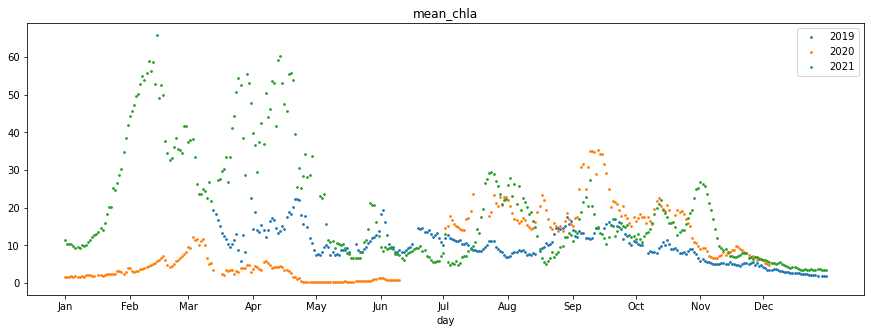

In [9]:
key = 'mean_chla'
fig,ax = plt.subplots(1,figsize=(15,5))

years = df['year'].unique()
for year in years:
    dfy = df[df['year']==year]
    yeardt = np.datetime64(str(year),'Y')
    n_days = (dfy['Datetime']-yeardt).dt.days
    ax.scatter(n_days,dfy[key],s=3)
ax.legend([str(year) for year in years])
ax.set_title(key)
ax.set_xlabel("day")
ax.set_xticks(fday)
ax.set_xticklabels(months)
plt.show()

[]

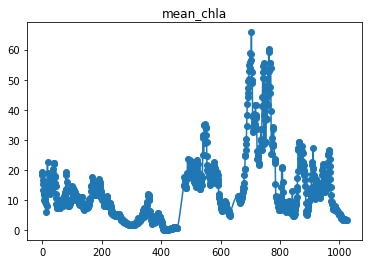

In [55]:
#interpolation
key='mean_chla'
dfd = df.drop('Datetime',axis=1)
dfi = dfd.interpolate(method='akima', limit_direction='forward', axis=0)
plt.scatter(np.arange(len(df)),df[key])
plt.plot(np.arange(len(dfi)),dfi[key])
plt.title(key)
plt.plot()

# Autocorrelation

## Full

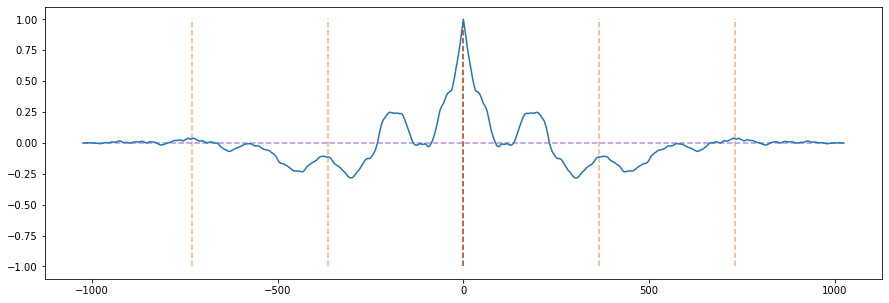

In [56]:
key = 'mean_chla'
fig,ax = plt.subplots(1,figsize=(15,5))

dfci = dfi-dfi.mean()
dfci = dfci.fillna(0)
autocor = signal.correlate(dfci[key],dfci[key], mode='full').astype(float)
autocor /=np.max(autocor)#dfci[key].std()*dfci[key].std()*len(dfci[key])
lags = signal.correlation_lags(len(dfci[key]), len(dfci[key]), mode='full')
ax.plot(lags,autocor)
for k in range(-len(years)+1,len(years)):
    if k==0:
        ax.vlines(0, -1, 1,linestyles='dashed',color='xkcd:rust')
    else:
        ax.vlines(365*k, -1, 1,linestyles='dashed',color='xkcd:peach')
ax.hlines(0,lags[0],lags[-1],linestyles='dashed',color='xkcd:pale purple')

### Normalization methods:
#### Mean

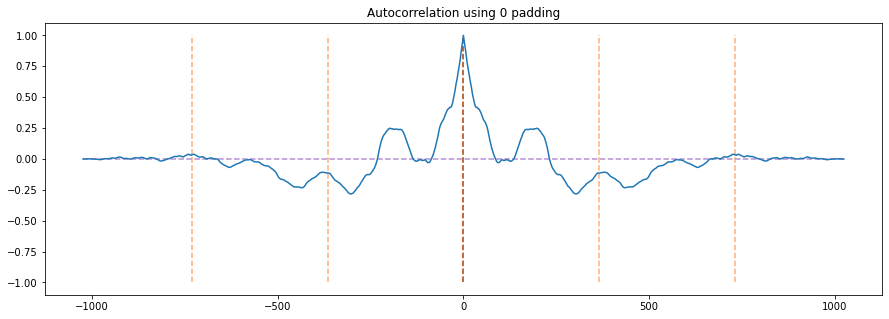

In [67]:
key = 'mean_chla'
fig,ax = plt.subplots(1,figsize=(15,5))

dfci = dfi-dfi.mean()
dfci = dfci.fillna(0)
autocor = signal.correlate(dfci[key],dfci[key], mode='full').astype(float)
autocor /=dfci[key].std()*dfci[key].std()*len(dfci[key])
lags = signal.correlation_lags(len(dfci[key]), len(dfci[key]), mode='full')
ax.plot(lags,autocor)
for k in range(-len(years)+1,len(years)):
    if k==0:
        ax.vlines(0, -1, 1,linestyles='dashed',color='xkcd:rust')
    else:
        ax.vlines(365*k, -1, 1,linestyles='dashed',color='xkcd:peach')
ax.hlines(0,lags[0],lags[-1],linestyles='dashed',color='xkcd:pale purple')
ax.set_title("Autocorrelation using 0 padding")
plt.show()

#### Periodicity

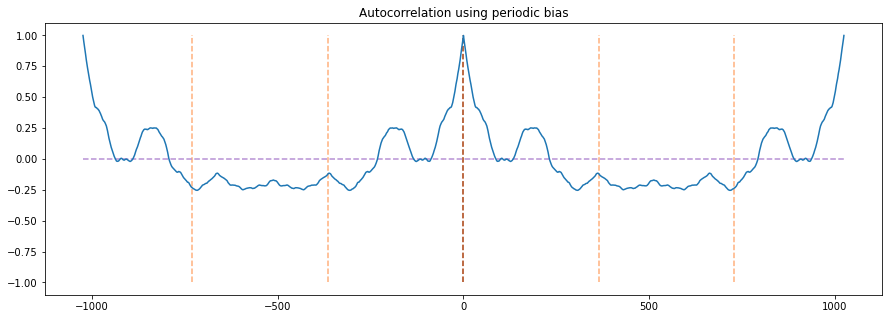

In [59]:
key = 'mean_chla'
fig,ax = plt.subplots(1,figsize=(15,5))

dfci = dfi-dfi.mean()
dfci = dfci.fillna(0)
autocor =  signal.correlate(dfci[key].append(dfci[key]),dfci[key], mode='valid').astype(float)
autocor /= dfci[key].std()*dfci[key].std()*len(dfci[key])
lags = signal.correlation_lags(len(dfci[key])*2, len(dfci[key]), mode='valid')
ax.plot(np.concatenate((np.flip(-lags),lags)),np.concatenate((autocor,autocor)))
for k in range(-len(years)+1,len(years)):
    if k==0:
        ax.vlines(0, -1, 1,linestyles='dashed',color='xkcd:rust')
    else:
        ax.vlines(365*k, -1, 1,linestyles='dashed',color='xkcd:peach')
ax.hlines(0,-lags[-1],lags[-1],linestyles='dashed',color='xkcd:pale purple')
ax.set_title("Autocorrelation using periodic bias")
plt.show()

#### Autocorrelation by recomputing statistics

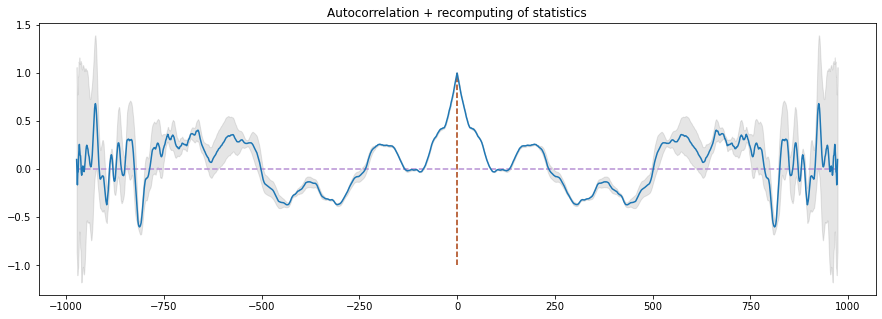

In [255]:
def autovariance(serie):
    lags = signal.correlation_lags(len(serie), len(serie), mode='full')
    autocor = np.zeros(len(lags))

    for idx in range(1,len(serie)+1):
        input1 = serie[:idx]
        input1 = (input1-input1.mean())/input1.std()
        input1.reset_index(drop=True,inplace=True)
        input2 = serie[-idx:]
        input2 = (input2-input2.mean())/input2.std()
        input2.reset_index(drop=True,inplace=True)

        autocor[idx-1]=np.mean(input1*input2)
        autocor[-idx]=autocor[idx-1]
    serie = (serie-serie.mean())/serie.std()
    return autocor

def autovar_rep(serie_base,n_rep=50):
    lags = signal.correlation_lags(len(serie_base)-n_rep, len(serie_base)-n_rep, mode='full')
    autocor_a = np.zeros((n_rep,len(lags)))
    for i in range(n_rep):
        serie = serie_base[i:-n_rep+i]
        autocor_a[i,:] = autovariance(serie)
    return autocor_a

key = 'mean_chla'
fig,ax = plt.subplots(1,figsize=(15,5))


serie_base = dfci[key]
serie_base = serie_base.dropna()

n_rep = 50
autocor_a = autovar_rep(serie_base,n_rep)
mean = np.mean(autocor_a,axis=0)
std = np.std(autocor_a,axis=0)
shade = ax.fill_between(lags, mean - 1.96*std, mean + 1.96*std,
                        color='gray', alpha=0.2) 
ax.plot(lags,mean)
    
for k in [0]:#range(-len(years)+1,len(years)):
    if k==0:
        ax.vlines(0, -1, 1,linestyles='dashed',color='xkcd:rust')
    else:
        ax.vlines(365*k, -1, 1,linestyles='dashed',color='xkcd:peach')
ax.hlines(0,lags[1],lags[-2],linestyles='dashed',color='xkcd:pale purple')
ax.set_title("Autocorrelation + recomputing of statistics")
plt.show()

### Plot all auto correlations:

In [263]:
len(lags)

1649

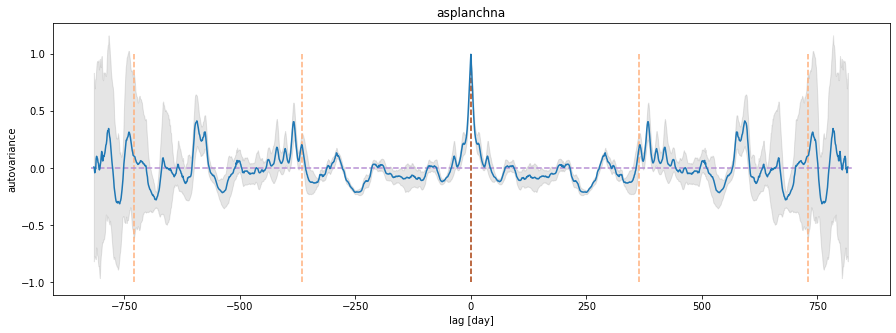

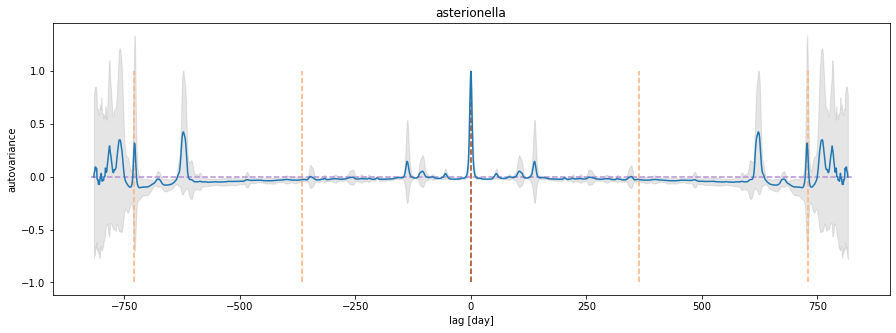

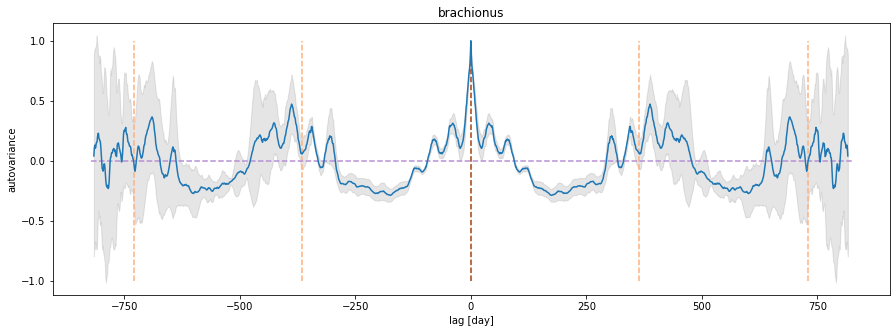

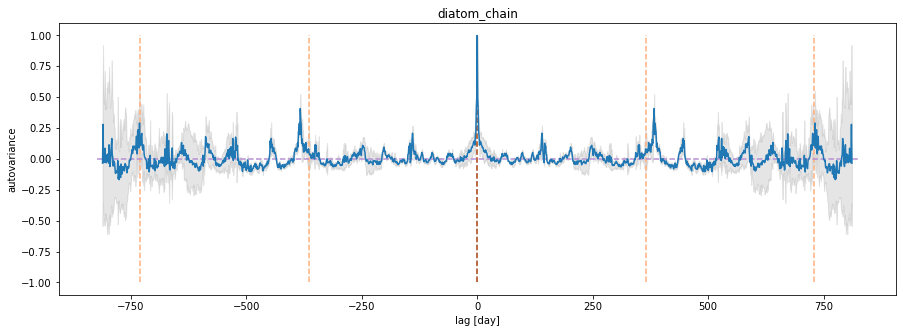

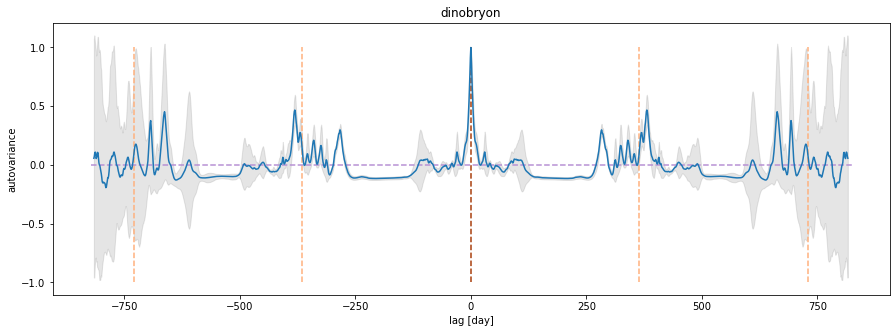

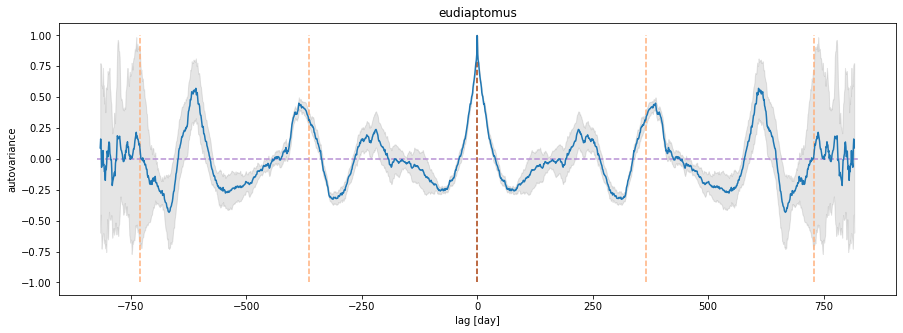

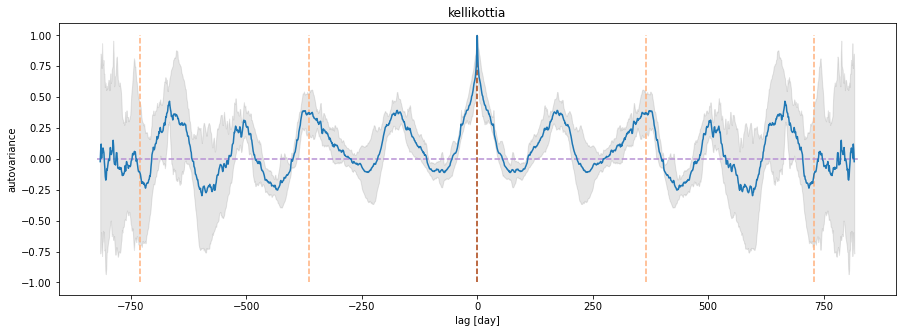

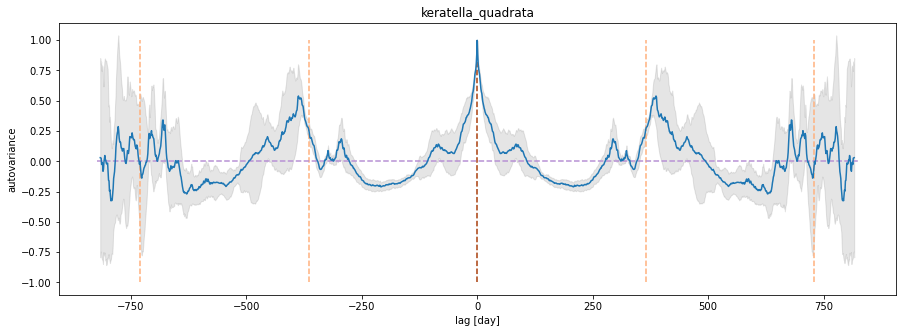

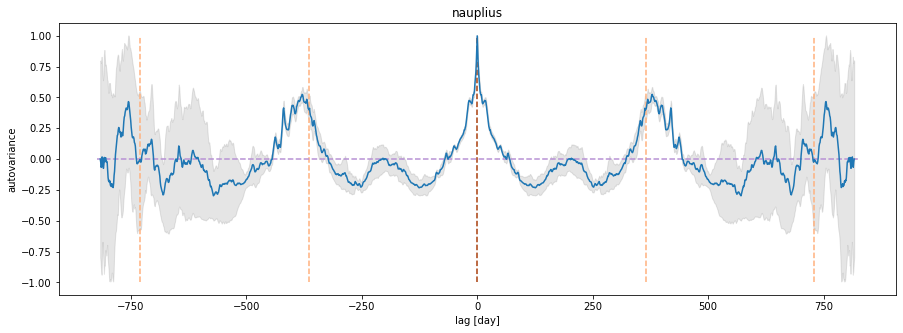

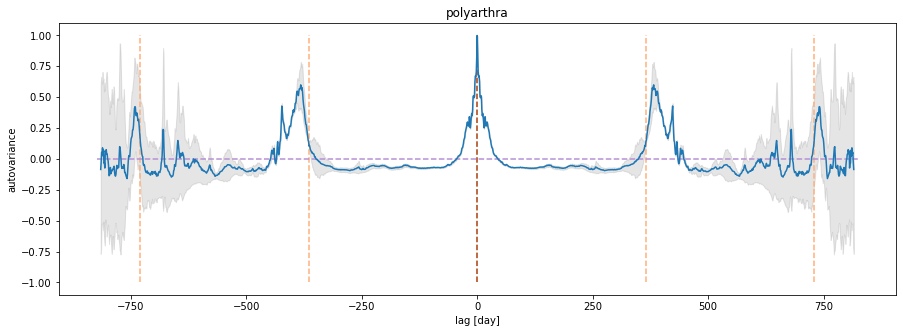

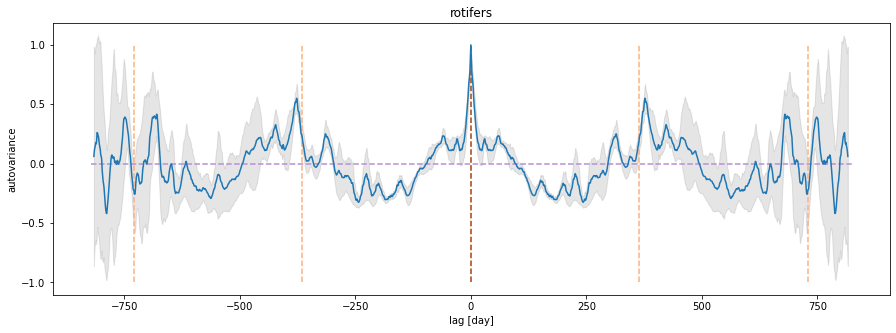

In [ ]:
n_reps = 200
for key in dfi.keys():
    fig,ax = plt.subplots(figsize=(15,5))
    serie =dfci[key].dropna()
    autocor_a = autovar_rep(serie,n_reps)
    mean = np.mean(autocor_a,axis=0)
    std = np.std(autocor_a,axis=0)
    
    lags = signal.correlation_lags(len(serie)-n_reps, len(serie)-n_reps, mode='full')
    ax.plot(lags,mean)
    shade = ax.fill_between(lags, mean - 1.96*std, mean + 1.96*std,
                            color='gray', alpha=0.2) 
    for k in range(-len(years)+1,len(years)):
        if k==0:
            ax.vlines(0, -1, 1,linestyles='dashed',color='xkcd:rust')
        else:
            ax.vlines(365*k, -1, 1,linestyles='dashed',color='xkcd:peach')
    ax.hlines(0,lags[1],lags[-1],linestyles='dashed',color='xkcd:pale purple')
    ax.set_title(key)
    ax.set_xlabel('lag [day]')
    ax.set_ylabel('autovariance')
    plt.show()

## Rolling window:


In [12]:
def windowed_cor(df,key1,key2,window_size,max_lag,epsilon=0.0001):
    cor = np.zeros((max_lag,len(df)-window_size-max_lag))
    dfd = df.drop('Datetime',axis=1,errors='ignore')
    for start in range(len(df)-window_size-max_lag):
        for lag in range(max_lag):
            input1=dfd[key1][start:start+window_size]
            input1.interpolate(method='linear', limit_direction='forward', axis=0)
            input1=input1-input1.mean()
            input1.reset_index(drop=True,inplace=True)
            input2=dfd[key2][start+lag:start+window_size+lag]
            input2.interpolate(method='linear', limit_direction='forward', axis=0)
            input2=input2-input2.mean()
            input2.reset_index(drop=True,inplace=True)
            
            cor[lag,start] =(input1*input2).mean()/(input1.std()*input2.std()+epsilon)
    
            
    return cor

In [15]:
max_lag  = 180
cor15 = windowed_cor(dfi,'mean_chla','mean_chla',15,max_lag)
cor30 = windowed_cor(dfi,'mean_chla','mean_chla',30,max_lag)
cor90 = windowed_cor(dfi,'mean_chla','mean_chla',90,max_lag)
cor180 = windowed_cor(dfi,'mean_chla','mean_chla',180,max_lag)
cor365 = windowed_cor(dfi,'mean_chla','mean_chla',365,max_lag)

In [16]:
croscor30 = windowed_cor(dfi,'mean_temp','mean_chla',30,max_lag)

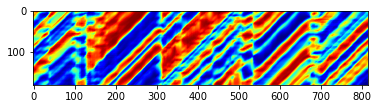

In [17]:
plt.imshow(croscor30,cmap='jet')

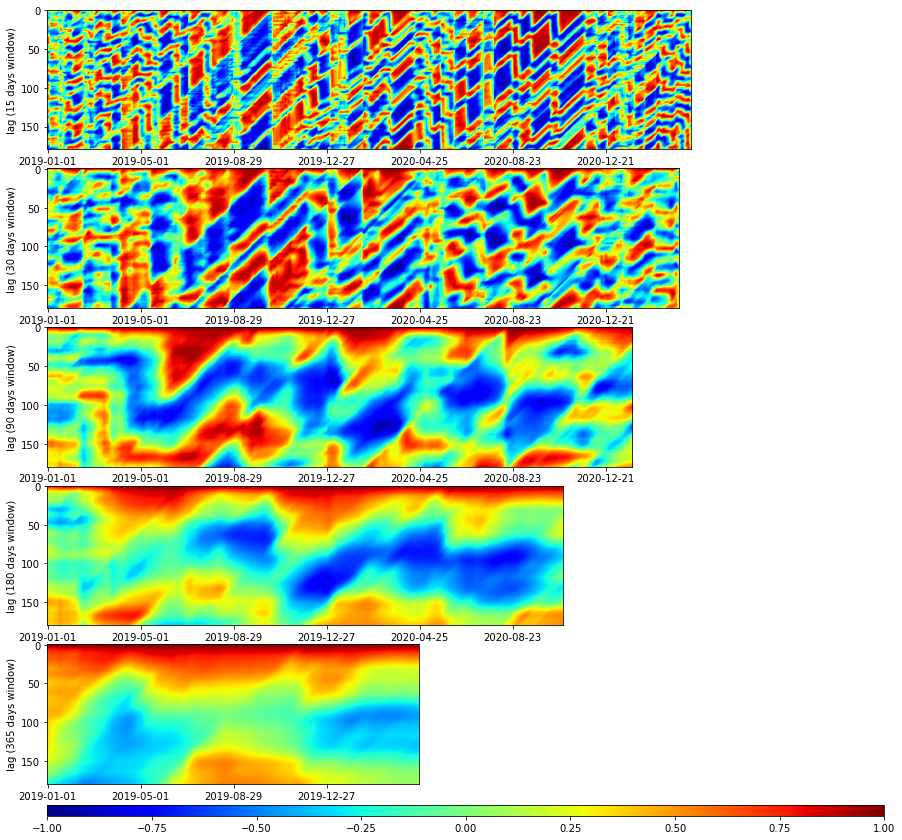

In [18]:
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('autocor_windowed.pdf')

img_list = [cor15,cor30,cor90,cor180,cor365]
name_list = [15,30,90,180,365]
padding = 30
w = 15
n = max(30+len(img_list)*padding+sum([img.shape[0] for img in img_list]),cor15.shape[1])
fig = plt.figure(figsize=(15,15))

gs = fig.add_gridspec(n,n)
axs=[]
ori = 0
for cor,name in zip(img_list,name_list):
    end = ori+padding+cor.shape[0]
    ax = fig.add_subplot(gs[ori:end,:cor.shape[1]])
    ori = end
    xticks = np.arange(0,cor.shape[1],120)
    ax.set_xticks(xticks)
    ax.set_xticklabels([el.date() for el in time_df[xticks]])
    ax.set_ylabel(f"lag ({name} days window)")
    axs.append(ax)
    img = ax.imshow(cor,cmap=plt.get_cmap('jet'),vmin=-1.,vmax=1.,aspect='equal')


ax_cb = fig.add_subplot(gs[ori+15:ori+30,:],)
fig.colorbar(img,cax=ax_cb,orientation='horizontal')
pp.savefig()
pp.close()
plt.show()

To allow an easier observation, the plots can be checked separately below:

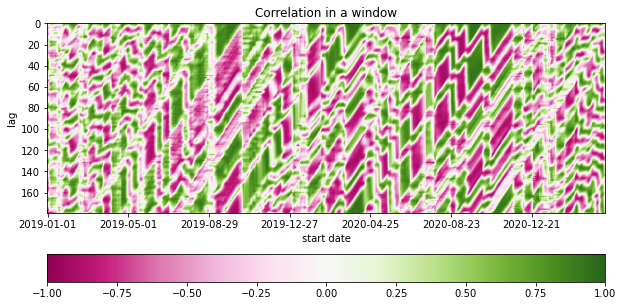

In [259]:
cor = cor15
fig,ax = plt.subplots(1,figsize=(10,5))
im = ax.imshow(cor,cmap=plt.get_cmap('PiYG'),vmin=-1.,vmax=1.,aspect='auto')
xticks = np.arange(0,cor.shape[1],120)
ax.set_xticks(xticks)
ax.set_xticklabels([el.date() for el in time_df[xticks]])
ax.set_xlabel("start date")
ax.set_ylabel("lag")
ax.set_title("Correlation in a window")
plt.colorbar(im,orientation='horizontal')

In case one wants to compare a perticular date accros the years, it is possible to simply put the wanted date down there

In [ ]:
n_day = 140 #days since january the first
cor = cor15


plot_interactive(n_day,cor=cor)
plt.show()


In [ ]:
cor = cor90


fig = plt.figure(figsize=(10,6))
gs = fig.add_gridspec(2, 30)
axs=[]
axs.append(fig.add_subplot(gs[0,:]))
axs.append(fig.add_subplot(gs[1,:-1]))
axs.append(fig.add_subplot(gs[1,-1]))
n_day  = 0
dates = np.arange(n_day,cor.shape[1],365)
cory = cor[:,dates]
# plot of the correlation
ax = axs[0]
lines = []
for corat in cory.T:
    line, = ax.plot(range(len(corat)),corat)
    lines.append(line)
ax.set_xlabel("Lag [day]")
ax.set_ylabel("Autocorrelation")
ax.set_ylim(-1.2,1.2)
mean = np.mean(cory,axis=1)
std = np.std(cory,axis=1)
shade = ax.fill_between(range(cory.shape[0]), mean - 1.96*std, mean + 1.96*std,
                        color='gray', alpha=0.2)

ax.legend([2019+el for el in range(cory.shape[1])]+["95% confidence interval"],loc='upper right')
ax.hlines(0,0,cory.shape[0],linestyles='dashed',color='black')
title = ax.set_title('')

#heat map with lines
ax = axs[1]
img = ax.imshow(cor,cmap='RdGy',vmin=-1,vmax = 1)

col = plt.cm.tab10([0.0,0.1,0.2])
vlines = []
for date in dates:
    vlines+=ax.plot([date,date],[0,cor.shape[0]-1],linestyle='dashed',
                          linewidth=4)
days = np.arange(0,cor.shape[1])
xticks = days[[el.is_month_start for el in time_df[:cor.shape[1]]]][::6]
ax.set_xticks(xticks)
ax.set_xticklabels([el.month_name()[:3]+f" {el.year}"
                    for el in time_df[xticks]])
ax.set_xlabel("start date")
ax.set_ylabel("lag")
#color bar
plt.colorbar(cax = axs[2],mappable=img,shrink=0.5,)


def animate(n_day):
    dates = np.arange(n_day,cor.shape[1],365)
    cory = cor[:,dates]
    #hide the lines when they go out of the frame
    if len(dates)<len(lines):
        for line in lines[len(dates)-len(lines):]:
            line.set_visible(False)
        for vline in vlines[len(dates)-len(lines):]:
            vline.set_visible(False)
            
    for line,vline,date in zip(lines,vlines,dates):
        line.set_ydata(cor[:,date])
        vline.set_xdata(date)
    
    mean = np.mean(cory,axis=1)
    std = np.std(cory,axis=1)
    newshade = axs[0].fill_between(range(cory.shape[0]), mean - 1.96*std, mean + 1.96*std,
                        color='gray', alpha=0.0)
    shade.set_paths([newshade.get_paths()[0].vertices])
    
    title.set_text(f"Autocorrelation starting on the"+
                   f" {str(df['day'][n_day]).zfill(2)}/{str(df['month'][n_day]).zfill(2)}")
    return [line for line in lines]+[vline for vline in vlines]+[shade]+[title]
ani = animation.FuncAnimation(
    fig, animate,frames = range(0,365,3), interval=100, blit=False, save_count=50)

plt.close(fig)

HTML(ani.to_jshtml())

In [22]:
file = open("animation.html","w")
file.write(ani.to_jshtml())
file.close()

NameError: name 'ani' is not defined

Two more informations could be useful: The mean and variance of the autocorrelation over the years

In [707]:
cor = cor15
def yearly_cor(cor):
    
    #add each year on a new axis:
    n_years = math.ceil(cor.shape[1]/365)
    cory = np.zeros((cor.shape[0],365,n_years))
    for y in range(n_years):
        #check the number of days left in the original array
        n_days = cor.shape[1]-(y+1)*365
        if n_days < 0:
            cory[:,:n_days,y]=cor[:,y*365:]
            cory[:,n_days:,y]=np.nan
        else:
            cory[:,:,y] = cor[:,y*365:(y+1)*365]
    return cory
    
cory = yearly_cor(cor)

In [854]:
#prepare the tickslabels
months=[]
fday = []
for day in range(1,366):
    dstr = str(day)
    date = datetime.strptime("2019-" + dstr, "%Y-%j")
    months.append(date.strftime("%b"))
months,fday = np.unique(months,return_index=True)
#the months are not in order, but the ticks are still correct
print(months)
print(fday)

['Apr' 'Aug' 'Dec' 'Feb' 'Jan' 'Jul' 'Jun' 'Mar' 'May' 'Nov' 'Oct' 'Sep']
[ 90 212 334  31   0 181 151  59 120 304 273 243]


In [901]:
max_lag=365
cor = windowed_cor(dfi,'mean_temp','mean_chla',30,max_lag)
cory = yearly_cor(cor)

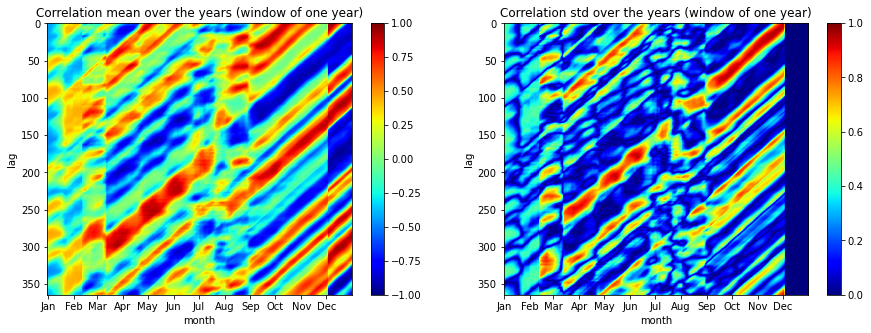

In [903]:
fig,axs = plt.subplots(1,2,figsize=(15,5))

#mean
ax = axs[0]
mean_cor = np.nanmean(cory[:max_lag,:,:],axis=2)
img=ax.imshow(mean_cor,cmap='jet',vmin=-1,vmax=1,aspect='auto')
ax.set_title(f"Correlation mean over the years (window of one year)")
ax.set_xlabel("month")
ax.set_xticks(fday)
ax.set_xticklabels(months)
ax.set_ylabel("lag")
plt.colorbar(img,ax=ax)

#std
ax = axs[1]
std_cor = np.nanstd(cory[:max_lag,:,:],axis=2)
img=ax.imshow(std_cor,cmap='jet',vmin=0,vmax=1,aspect='auto')
ax.set_title(f"Correlation std over the years (window of one year)")
ax.set_xlabel("month")
ax.set_xticks(fday)
ax.set_xticklabels(months)
ax.set_ylabel("lag")
plt.colorbar(img,ax=ax)
plt.show()

In [905]:
min_lag = 0
best_lag = np.argmax(np.sum(np.abs(mean_cor)[min_lag:],axis=1))+min_lag
best_lag/30

4.133333333333334

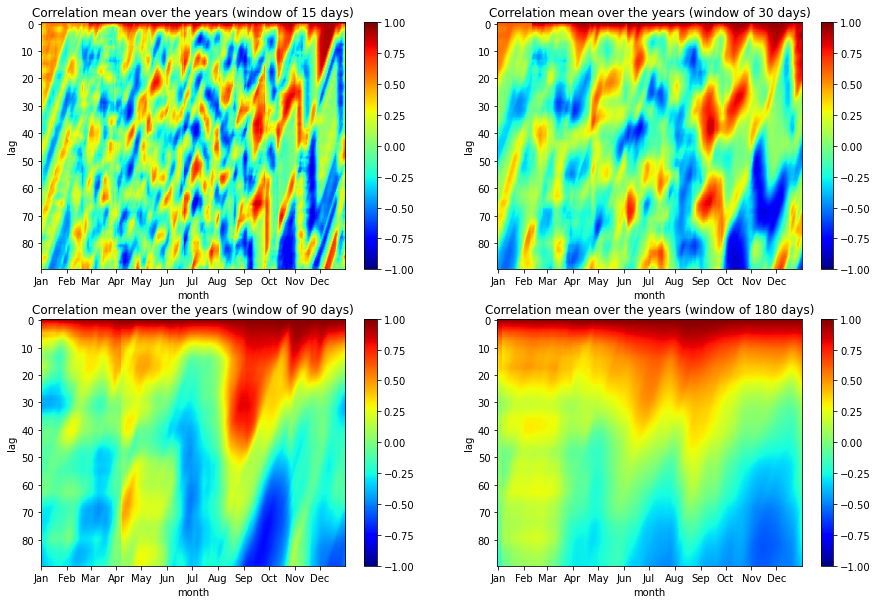

In [918]:
max_lag = 90
fig,axs = plt.subplots(2,2,figsize=(15,10))
axs = axs.ravel()
for idx,(cor,name) in enumerate(zip(img_list[:-1],name_list[:-1])):
    cory = yearly_cor(cor)
    mean_cor = np.nanmean(cory[:max_lag,:,:],axis=2)
    img=axs[idx].imshow(mean_cor,cmap='jet',vmin=-1,vmax=1,aspect='auto')
    axs[idx].set_title(f"Correlation mean over the years (window of {name} days)")
    axs[idx].set_xlabel("month")
    axs[idx].set_xticks(fday)
    axs[idx].set_xticklabels(months)
    axs[idx].set_ylabel("lag")
    plt.colorbar(img,ax=axs[idx])
plt.show()


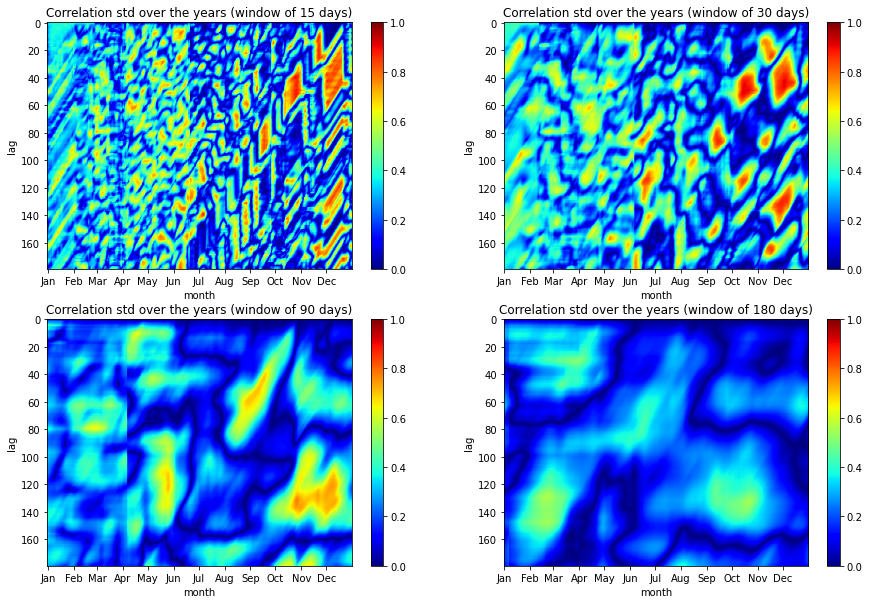

In [919]:
max_lag = 180
fig,axs = plt.subplots(2,2,figsize=(15,10))
axs = axs.ravel()
for idx,(cor,name) in enumerate(zip(img_list[:-1],name_list[:-1])):
    cory = yearly_cor(cor)
    mean_cor = np.nanstd(cory[:max_lag,:,:],axis=2)
    img=axs[idx].imshow(mean_cor,cmap='jet',vmin=0,vmax=1,aspect='auto')
    axs[idx].set_title(f"Correlation std over the years (window of {name} days)")
    axs[idx].set_xlabel("month")
    axs[idx].set_xticks(fday)
    axs[idx].set_xticklabels(months)
    axs[idx].set_ylabel("lag")
    plt.colorbar(img,ax=axs[idx])
plt.show()

#### Statistical view of the heat maps
As 

### Cross correlation of Chlorophyll a and key parameters

In [950]:
croscor_d = {}
max_lag = 370
window_size = 30
for idx,key in enumerate(keys_imp):
    print(f"{idx}/{key}",end='\r')
    ccor = windowed_cor(dfi,key,'mean_chla',window_size,max_lag)
    ccory = yearly_cor(ccor)
    croscor_d[key] = {'wccor':ccory}

In [951]:
for d in croscor_d:
    print(d)

ciliate
mean_chla
cv_chla_day
cv_chla_depth
nauplius
Ammonium
Nitrat
mean_schmidt
windspeed_max
mean_thermocline_depth
mean_epi_temp
mean_oxycline_depth
mean_mixed_layer_depth
mean_global_radiation


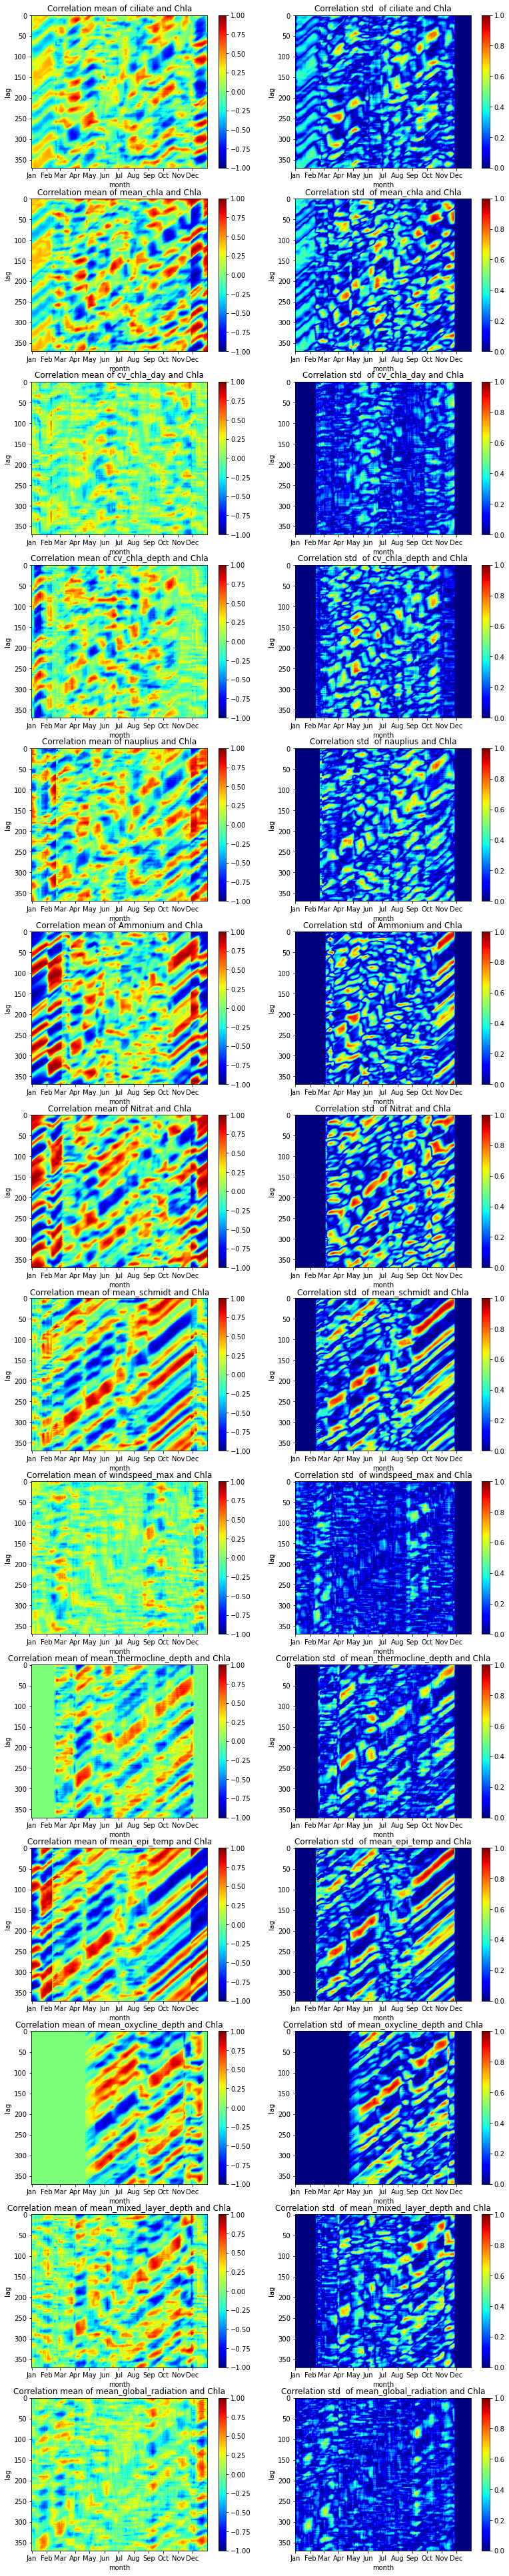

In [952]:
fig,axs = plt.subplots(len(croscor_d),2,figsize=(13,len(croscor_d)*5))
for idx,key in enumerate(croscor_d):
    #mean
    ax = axs[idx,0]
    mean_cor = np.nanmean(croscor_d[key]['wccor'],axis=2)
    img=ax.imshow(mean_cor,cmap='jet',vmin=-1,vmax=1,aspect='auto')
    ax.set_title(f"Correlation mean of {key} and Chla")
    ax.set_xlabel("month")
    ax.set_xticks(fday)
    ax.set_xticklabels(months)
    ax.set_ylabel("lag")
    plt.colorbar(img,ax=ax)

    #std
    ax = axs[idx,1]
    std_cor = np.nanstd(croscor_d[key]['wccor'],axis=2)
    img=ax.imshow(std_cor,cmap='jet',vmin=0,vmax=1,aspect='auto')
    ax.set_title(f"Correlation std  of {key} and Chla")
    ax.set_xlabel("month")
    ax.set_xticks(fday)
    ax.set_xticklabels(months)
    ax.set_ylabel("lag")
    plt.colorbar(img,ax=ax)
plt.show()

In [973]:
min_lags = [1,5,30]
max_lag = 370
np.linspace(0,365,5).astype(int)[:]
season = ['winter','spring','summer','fall']
for key in croscor_d:
    croscor_d[key]['best_lag']={}
    for min_lag in min_lags:
        min_lag
        for idx,season in enumerate(season)
        start_date = 
        ccor = np.nanmean(croscor_d[key]['wccor'],axis=2)
        croscor_d[key]['best_lag'][str(min_lag)]=np.argmax(np.sum(np.abs(ccor),axis=1)[min_lag:max_lag])+min_lag
    print(f"{key}: {croscor_d[key]['best_lag']}")

ciliate: {'1': 1, '5': 344, '30': 344}
mean_chla: {'1': 1, '5': 5, '30': 178}
cv_chla_day: {'1': 1, '5': 173, '30': 173}
cv_chla_depth: {'1': 83, '5': 83, '30': 83}
nauplius: {'1': 182, '5': 182, '30': 182}
Ammonium: {'1': 1, '5': 157, '30': 157}
Nitrat: {'1': 135, '5': 135, '30': 135}
mean_schmidt: {'1': 127, '5': 127, '30': 127}
windspeed_max: {'1': 302, '5': 302, '30': 302}
mean_thermocline_depth: {'1': 353, '5': 353, '30': 353}
mean_epi_temp: {'1': 160, '5': 160, '30': 160}
mean_oxycline_depth: {'1': 86, '5': 86, '30': 86}
mean_mixed_layer_depth: {'1': 212, '5': 212, '30': 212}
mean_global_radiation: {'1': 260, '5': 260, '30': 260}


array([  0,  91, 182, 273, 365])

In [980]:
import pickle
file = 'cros_cor_dict.pickle'
with open(file, 'wb') as f:
    pickle.dump(croscor_d, f)

The results are hard to interpret, check the kalman forest notebook to see how they are used